<a href="https://colab.research.google.com/github/SophiaES/Test/blob/main/Intro_To_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 추천 시스템 실습
### [MovieLens](https://grouplens.org/datasets/movielens/) 영화 별점 데이터를 이용해 영화 추천 시스템을 만들어보자

In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib as mpl
from matplotlib import pyplot as plt
import sklearn

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

## Matplotlib 한글 폰트 설치 및 설정
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


^C


AttributeError: ignored

[GroupLens 웹사이트](https://grouplens.org/datasets/movielens/)를 통해 데이터를 다운받자. [MovieLens](https://movielens.org/) 웹사이트를 통해 미국인들을 대상으로 자기가 본 영화에 대해 별점을 매기게해 25,000,000개의 별점(1-5)을 모아 놓았으며 교육을 목적으로 다양한 크기의 데이터셋을 공개하고 있다. 시작은 일단 10만 레이팅을 담고 있는 데이터셋을 사용하여 구현 후 크기를 늘리자. 

In [ ]:
# MovieLens 데이터 다운
print("MovieLens 데이터 다운 중...")
from urllib.request import urlretrieve
import zipfile

data_filename = "ml-latest-small"
urlretrieve(f"http://files.grouplens.org/datasets/movielens/{data_filename}.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall() 
print("데이터 다운 완료.")

# 데이터를 로드하자
ratings = pd.read_csv(
    f'{data_filename}/ratings.csv', sep=',', header=0, encoding='latin-1')

movies = pd.read_csv(
    f'{data_filename}/movies.csv', sep=',', header=0, encoding='latin-1')

# id가 1에서 시작한다. Python에서 다루기 쉽게 0-index로 바꿔주자. 
movies["movieId"] = movies["movieId"].apply(lambda x: int(x-1))
ratings["movieId"] = ratings["movieId"].apply(lambda x: int(x-1))
ratings["userId"] = ratings["userId"].apply(lambda x: int(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

num_users = len(ratings["userId"].unique())
num_movies = len(movies)
num_ratings = len(ratings)
print(f"데이터 로드 완료: 사용자 수 - {num_users}, 영화 수 - {num_movies}, 별점 수 - {num_ratings}")

MovieLens 데이터 다운 중...
데이터 다운 완료.
데이터 로드 완료: 사용자 수 - 610, 영화 수 - 9742, 별점 수 - 100836


In [ ]:
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,4.000,964982703
1,0,2,4.000,964981247
2,0,5,4.000,964982224
3,0,46,5.000,964983815
4,0,49,5.000,964982931


# 데이터 탐험하기
본격적으로 추천 시스템 알고리즘을 구현하기 전에 데이터에 대해 더 자세히 알아보자. 



## 사용자에 대해 알아보자

사용자들이 별점을 주는 패턴을 분석해보자. 각 사용자별로 몇개의 영화에 별점을 주었는지 그 별점의 평균은 무엇인지 알아보자. 이를 통해 무엇을 알 수 있을까? 실무에서는 몇개의 outlier로 인해 결과물이 좌지우지될 수 있다.

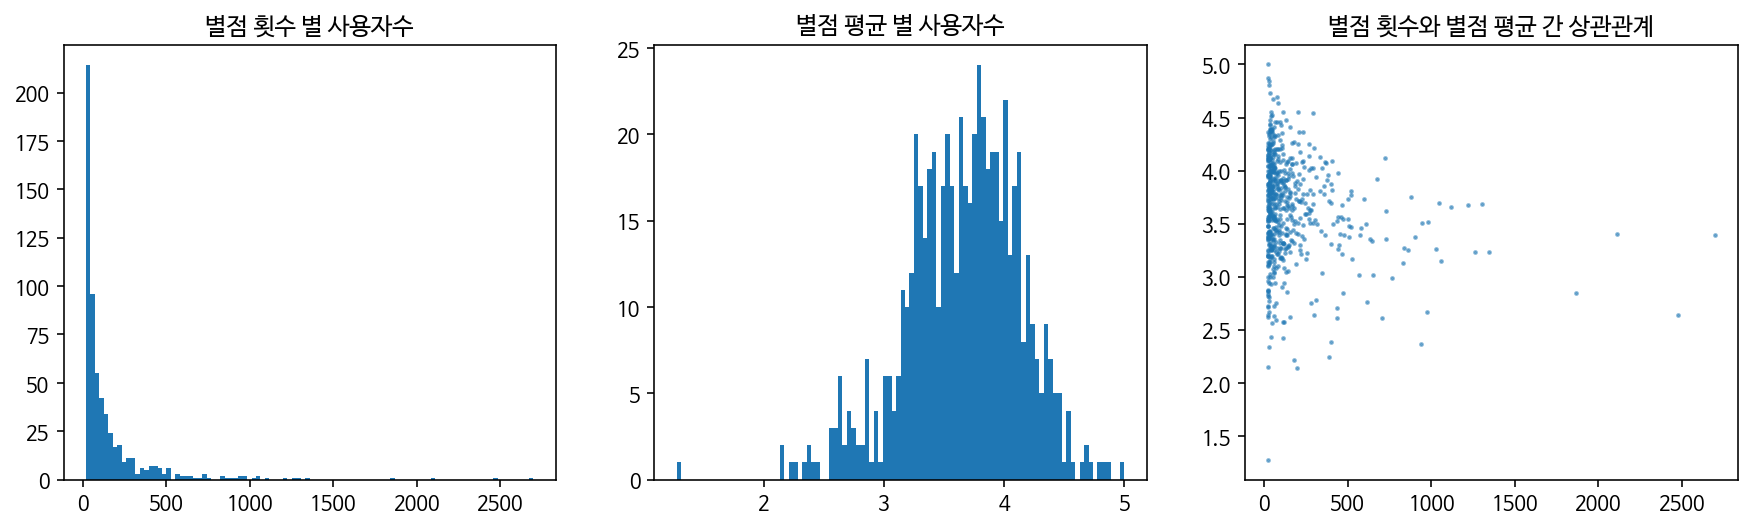

In [ ]:
user_rating_stats = ratings\
  .groupby('userId', as_index=False)\
  .agg({'rating': ['count', 'mean']})
user_rating_stats.columns = ['_'.join(col).strip('_') for col in user_rating_stats.columns.values]
f, axs = plt.subplots(1, 3, figsize=[15, 4])
axs[0].hist(user_rating_stats['rating_count'], bins=100)
axs[0].set_title('별점 횟수 별 사용자수')
axs[1].hist(user_rating_stats['rating_mean'], bins=100)
axs[1].set_title('별점 평균 별 사용자수')
axs[2].scatter(user_rating_stats['rating_count'], user_rating_stats['rating_mean'], s=2, alpha=0.5)
axs[2].set_title('별점 횟수와 별점 평균 간 상관관계')
f.show()

대부분의 사용자가 적은 갯수의 영화에 별점을 메겼다는 것을 볼 수 있으며, 400개 이상의 영화에 별점을 메긴 유저들도 존재한다는 것을 알 수 있다. 또한 대체적으로 3개에서 4개 사이의 별점을 주며 별점 횟수와 별점 평균간 상관관계는 없다는 것을 알 수 있다. 

## 컨텐츠(영화)에 대해 알아보자

먼저 각 특성별 (수치형-numerical 그리고 범주형-categorical) 기본 통계부터 알아보자

In [ ]:
movies.describe(include=[np.object])

,title,genres
count,9742,9742
unique,9737,951
top,Confessions of a Dangerous Mind (2002),Drama
freq,2,1053


In [ ]:
all_genres = sorted(set(genre for genres in movies['genres'].unique() for genre in genres.split('|')))
all_genres.remove('(no genres listed)')
for genre in all_genres:
  movies[genre] = movies['genres'].apply(lambda genres: 1 if genre in genres else 0)

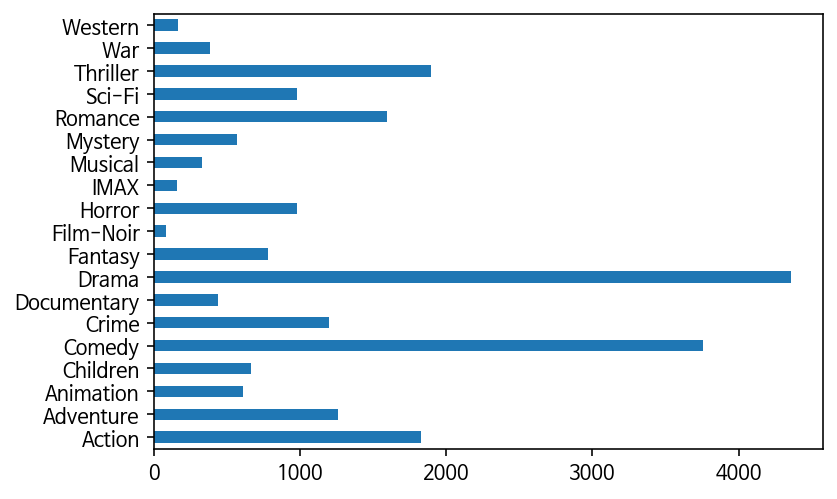

In [ ]:
movies[all_genres].sum().plot(kind='barh')

다음은 사용자와 마찬가지로 각 영화별 별점을 몇 번 받았는지 그리고 평균 몇점을 받았는지 알아보자. 

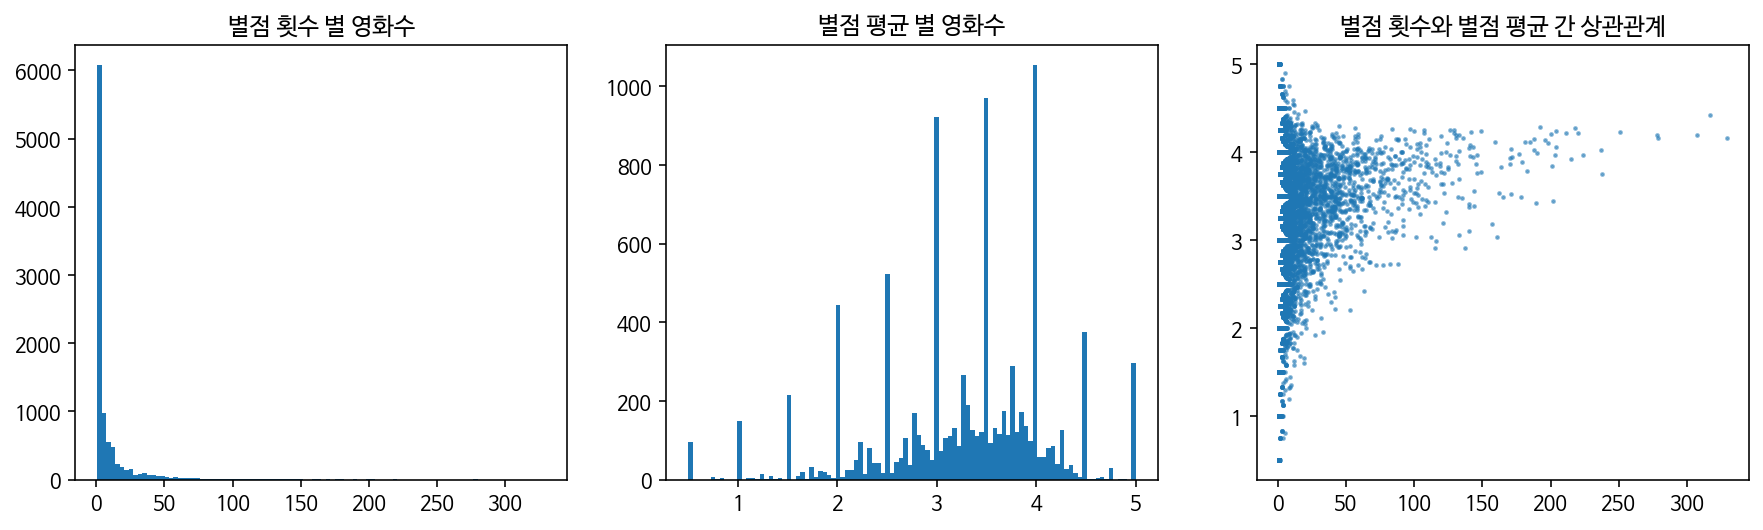

In [ ]:
movies_rating_stats = ratings\
  .groupby('movieId', as_index=False)\
  .agg({'rating': ['count', 'mean']})
movies_rating_stats.columns = ['_'.join(col).strip('_') for col in movies_rating_stats.columns]
f, axs = plt.subplots(1, 3, figsize=[15, 4])
axs[0].hist(movies_rating_stats['rating_count'], bins=100)
axs[0].set_title('별점 횟수 별 영화수')
axs[1].hist(movies_rating_stats['rating_mean'], bins=100)
axs[1].set_title('별점 평균 별 영화수')
axs[2].scatter(movies_rating_stats['rating_count'], movies_rating_stats['rating_mean'], s=2, alpha=0.5)
axs[2].set_title('별점 횟수와 별점 평균 간 상관관계')
f.show()

사용자와 마찬가지로 별점 횟수가 적은 영화가 대부분이지만 300개 이상의 별점을 받은 영화도 존재하며 별점 평균 또한 3개에서 4개 사이에 제일 많이 분포한다. 하지만 사용자에 비해 아주 적은 별점을 받은 영화가 많아 별점 평균이 더 고르게 분포해있으며 별점을 많이 받을수록 별점 평균 또한 높은 것을 알 수 있다. 

# 알고리즘을 구현하기 전 준비 과정

MovieLens와 같은 경우 데이터가 깨끗하게 정리되어 있기 때문에 데이터 전처리 (preprocessing) 과정이 필요 없으니 추천 알고리즘 구현과 평가를 위해 학습 세트(training data)와 테스트 세트(test data)로 나누자. 

데이터를 나누는 방식은 다양하며 주어진 데이터에 따라 맞는 방식을 결정해야한다. 제일 직관적인 방식은 각 데이터 행을 랜덤하게 나누는 방식이다. 제일 간단하며 이번 실습에서 사용할 방법이지만 실무에서는 시간에 따라 나누는 경우가 많다. 예를들어 3달간의 데이터(학습 세트)로 훈련 시킨 후 그 다음 2주간의 데이터(테스트 세트)로 평가한 후 평가 지표가 제일 높게 나온 모델 아키텍처와 초매개변수(hyperparameter)을 찾는다. 이를 바탕으로 학습 세트와 테스트 세트를 모은 데이터를 이용해 재훈련 시킨 후 실제 제품에 적용시킨다. 이런 방식으로 가장 최근의 데이터를 이용해 훈련하면서도 객관적으로 평가할 수 있다. 

물론 MovieLens의 경우 각 사용자별로 사이트에 들어와 별점을 입력한 시간이 다르기때문에 시간에 따라 나누게되면 어떤 유저의 별점 데이터는 모두 학습 세트에 또는 모두 테스트 세트에 들어가게 되어 평가가 어려워진다. 데이터를 80-20 비율로 랜덤하게 나누자. 

In [ ]:
from sklearn.model_selection import train_test_split

data = ratings.merge(movies, on='movieId')
## random_state이 같으면 같은 데이터에 대해 같은 결과물이 나온다. 
training_data, test_data = train_test_split(data, test_size=0.2, random_state=0) 
print(f"학습 데이터: {len(training_data)}, 테스트 데이터: {len(test_data)}")

학습 데이터: 80668, 테스트 데이터: 20168


위의 테스트 세트를 바탕으로 다양한 평가 기법을 구현하자. 이전 강의에서 배웠던 기법들을 정리해보자. 

1. 모델 정확도 기법
모델이 얼마나 실제와 같은 예측을 했는지 측정한다. 다시 말해, 예측 별점과 실제 별점의 차이를 측정한다. 그 중 [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)를 측정해보자. 

2. 결정 정확도 기법
모델이 예측한 결과에 따라 추천을 했을 때 그중 실제로 소비될지 안될지 측정한다. 이 경우 4점 이상의 별점을 주었을때 소비되었다고 가정한다. 그 중 [Precision@K, Recall@K](https://en.wikipedia.org/wiki/Precision_and_recall)를 측정해보자. 

3. 순서 정확도 기법
모델이 예측한 결과에 따라 추천을 했을 때 보여준 순서가 얼마나 적합한지 측정한다. 그중 [NDCG@K](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)를 측정해보자. 

입력값은 테스트 세트와 테스트 세트의 각 행(userId, movieId)마다의 예측 별점이라고 가정하자. 

In [ ]:
from collections import defaultdict
import heapq
from statistics import mean
from sklearn.metrics import ndcg_score

def rmse(test_data, pred):
  return np.sqrt(np.mean((test_data["rating"]-pred)**2))

## 결정/순서 정확도 지표는 각 사용자별로 측정 후 평균값을 구한다. 이를 쉽게하기 위해 각 사용자 별로
## 영화들의 실제 레이팅과 예측 레이팅을 그루핑해 저장하자. 
def groupby_user(test_data, pred):
  user_dict = defaultdict(lambda: ([], []))
  for user_id, rating, pred in zip(test_data["userId"], test_data["rating"], pred):
    user_dict[user_id][0].append(rating)
    user_dict[user_id][1].append(pred)
  return user_dict

## 정확도(Precision): 추천한 컨텐츠 중 실제 소비된 컨텐츠의 비율
def precision_at_k(actual, pred, k):
  top_k = heapq.nlargest(k, zip(pred, actual))
  tp = sum(1 if rating >= 4 else 0 for _, rating in top_k)
  return tp / len(top_k)

## 재현율(Recall): 실제 소비된 컨텐츠 중 추천된 컨텐츠의 비율
def recall_at_k(actual, pred, k):
  top_k = heapq.nlargest(k, zip(pred, actual))
  tp = sum(1 if rating >= 4 else 0 for _, rating in top_k)
  ap = sum(1 if rating >= 4 else 0 for rating in actual)
  return tp / ap if ap > 0 else 0

def ndcg_at_k(actual, pred, k):
  return ndcg_score(np.asarray([actual]), np.asarray([pred]), k=k) if len(actual) > 1 else 1.0

def get_metrics(test_data, pred):
  metrics = {}
  metrics["RMSE"] = rmse(test_data, pred)
  grouped_rating = groupby_user(test_data, pred)
  metrics["Precision@5"] = mean(precision_at_k(actual, pred, 5) for actual, pred in grouped_rating.values())
  metrics["Recall@5"] = mean(recall_at_k(actual, pred, 5) for actual, pred in grouped_rating.values())
  metrics["NDCG@5"] = mean(ndcg_at_k(actual, pred, 5) for actual, pred in grouped_rating.values())
  return metrics

# 추천 알고리즘

## 1. 무작위 그리고 인기도 기반 추천

강의 시간에 배운 추천 알고리즘들을 구현하기 전에 이들과 비교 대상이 될 간단한 알고리즘을 만들어보자. 먼저 무작위로 추천해보자. 

In [ ]:
np.random.seed(0)
random_pred = np.random.uniform(low=1.0, high=5.0, size=(len(test_data),))
random_metrics = get_metrics(test_data, random_pred)
print(random_metrics)

{'RMSE': 1.6414834211671057, 'Precision@5': 0.5707377049180328, 'Recall@5': 0.41535181655119774, 'NDCG@5': 0.8155866070481236}


각 아이템의 인기도에 따라 추천해보자. 여기서 인기도는 4점 이상의 별점을 받은 횟수로 정의하자. 물론 학습 데이터만으로 인기도를 측정해야한다. 

In [ ]:
movie_popularity = defaultdict(int)
for movie, rating in zip(training_data["title"], training_data["rating"]):
  if rating >= 4:
    movie_popularity[movie] += 1
popularity_pred = np.fromiter((movie_popularity[title] for title in test_data["title"]), int)
popularity_metrics = get_metrics(test_data, popularity_pred)
print(popularity_metrics)

{'RMSE': 43.63619072530816, 'Precision@5': 0.6792622950819672, 'Recall@5': 0.4646254811653813, 'NDCG@5': 0.8813544777873898}


인기도의 분포는 별점 분포와 완전히 다르기 때문에 RMSE는 굉장히 높지만 (물론 1.0과 5.0 사이로 오게 하여 줄일 수 있지만 별로 의미는 없다.) 결정과 순서 정확도는 훨씬 좋아진 것을 확인할 수 있다. 

실제로 어떤 영화들을 추천해주는지 알아보자. 

In [ ]:
N = 10
print(heapq.nlargest(N, movie_popularity, key=movie_popularity.get))

['Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Fight Club (1999)', "Schindler's List (1993)", 'Braveheart (1995)', 'Usual Suspects, The (1995)']


이처럼 "인기 영화"들을 추천해주는 것만으로도 어느정도의 성과를 얻을 수 있겠다. 

실무에서 추천 시스템을 만들때 바로 알고리즘 구현 시작하는 경우가 많지만 이처럼 아주 간단한 알고리즘을 먼저 구현하여 마지노선을 측정하자. (열심히 구현한 알고리즘이더라도 이들보다 못하면 전혀 의미가 없다)

## 2. 최근접 이웃 기반 협업 필터링

최근접 이웃 기반 협업 필터링 기법은 사용자 컨텐츠 사용 데이터를 바탕으로 각 객체간 유사도 측정 후 각 객체와 가장 유사도가 높은 N개의 최근접 이웃을 찾는다. 이 이웃들의 소비 패턴을 바탕으로 추천한다. 

먼저 학습 데이터를 기반하여 사용자 컨텐츠 소비 행렬을 만들자. 

In [ ]:
from scipy.sparse import csr_matrix
# 먼제 학습 데이터를 사용자 컨텐츠 사용 행렬 형태로 만들자
user_item_matrix = training_data.pivot_table(
    index='userId',
    columns='title',
    values='rating'
).fillna(0)

# 각 사용자와 영화 id의 index를 저장하자
user_ids = user_item_matrix.index.values
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
titles = user_item_matrix.columns.values
title_to_idx = {title: idx for idx, title in enumerate(titles)}

# 행렬의 대부분이 비어있기 때문에 Sparse Matrix 데이터 구조를 사용하자
user_item_matrix = csr_matrix(user_item_matrix.values)

이를 바탕으로 사용자 기반 추천 시스템을 구현해보자. [코사인 유사도](https://ko.wikipedia.org/wiki/%EC%BD%94%EC%82%AC%EC%9D%B8_%EC%9C%A0%EC%82%AC%EB%8F%84)를 바탕으로 각 사용자간 유사도를 계산하고 이를 바탕으로 가장 유사한 사용자를 찾자.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
# 각 행간의 차이를 계산해 행렬 형태로 출력해준다. (유사도의 반대 개념)
# 이 경우 사용자가 610명이니 610 * 610 행렬을 출력해준다. 
user_user_distance = pairwise_distances(user_item_matrix, metric='cosine')
# 각 행 별로 가장 차이가 적은 N개의 열들을 찾자. 
N = 10
nearest_neighbors = np.argpartition(user_user_distance, N+1)[:,:N+1]
print(nearest_neighbors)
# 각 사용자별 최근접 이웃의 별점 데이터를 평균내자
pred_ratings_per_user = [np.squeeze(np.asarray(user_item_matrix[nearest_neighbors[user_id, :]].mean(axis=0))) for user_id in range(user_user_distance.shape[0])]

[[ 56   0 576 ...  90 287 596]
 [  1 527 494 ... 226 536 377]
 [312 270   2 ... 276 554 560]
 ...
 [ 44 437 607 ...  63  67 273]
 [378 484 608 ... 241 529 467]
 [248 609 297 ... 218 413 560]]


테스트 데이터의 각 유저별로 가장 근접한 유저의 별점을 평균내어 이를 바탕으로 별점을 예측해보자. 

In [ ]:
user_nn_pred = []
for user_id, title in zip(test_data["userId"], test_data["title"]):
  if user_id in user_id_to_idx and title in title_to_idx:
    # 학습 데이터에 존재하는 사용자와 영화의 경우 미리 평균낸 별점 데이터를 가져오자
    user_nn_pred.append(pred_ratings_per_user[user_id_to_idx[user_id]][title_to_idx[title]])
  # 학습 데이터에 존재하지 않는 사용자나 영화의 경우 0.0의 별점을 준다. 
  else: 
    user_nn_pred.append(0.0)
user_nn_metrics = get_metrics(test_data, user_nn_pred)

In [ ]:
print(user_nn_metrics)
print(popularity_metrics)
print(random_metrics)

{'RMSE': 2.824412509173746, 'Precision@5': 0.6831967213114755, 'Recall@5': 0.467705106832396, 'NDCG@5': 0.8792428635241838}
{'RMSE': 43.63619072530816, 'Precision@5': 0.6792622950819672, 'Recall@5': 0.4646254811653813, 'NDCG@5': 0.8813544777873898}
{'RMSE': 1.6414834211671057, 'Precision@5': 0.5707377049180328, 'Recall@5': 0.41535181655119774, 'NDCG@5': 0.8155866070481236}


정밀도와 재현율은 인기도 기반 추천에 비해 높지만 NDCG는 낮은 것을 볼 수 있다. 

이제 Spot Checking을 통해 어떤 추천을 해주는지 알아보자. 

In [ ]:
def convert_rating_dict_to_vector(rating_dict):
  # 사용자의 별점 데이터를 소비 데이터와 동일한 형태의 sparse matrix로 변환하자
  rows, cols, data = [], [], []
  for title, rating in rating_dict.items():
    if title in title_to_idx:
      rows.append(0)
      cols.append(title_to_idx[title])
      data.append(rating)
  return csr_matrix((data, (rows, cols)), shape=(1, user_item_matrix.shape[1]))

# 사용자의 별점 데이터 (영화 이름 -> 별점)을 바탕으로 어떤 영화들을 추천해줄까?
def get_user_nn_recommendations(rating_dict, n_recs):
  mat = convert_rating_dict_to_vector(rating_dict)
  # 학습 데이터의 각 사용자와 유사도를 측정하자
  distances = np.squeeze(np.asarray(pairwise_distances(user_item_matrix, mat, metric='cosine')))
  # 최근접 이웃을 찾고 이들의 별점 데이터를 평균내자
  nearest_neighbors = np.argpartition(distances, N+1)[:N+1]
  pred_ratings = np.squeeze(np.asarray(user_item_matrix[nearest_neighbors].mean(axis=0))) 
  return [titles[id] for id, _ in heapq.nlargest(n_recs, enumerate(pred_ratings), key=lambda tup: tup[1])]

user1 = {"Forrest Gump (1994)": 5.0, "Star Wars: Episode IV - A New Hope (1977)": 1.0}
print(get_user_nn_recommendations(user1, 10))
user2 = {"Forrest Gump (1994)": 1.0, "Star Wars: Episode IV - A New Hope (1977)": 5.0}
print(get_user_nn_recommendations(user2, 10))

['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'Braveheart (1995)', 'Apollo 13 (1995)', 'Silence of the Lambs, The (1991)', 'Jurassic Park (1993)', "Schindler's List (1993)", 'Usual Suspects, The (1995)', 'Ghost (1990)', 'Matrix, The (1999)']
['Star Wars: Episode IV - A New Hope (1977)', 'Shawshank Redemption, The (1994)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Dark Knight, The (2008)', 'Gladiator (2000)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Saving Private Ryan (1998)', 'Spider-Man (2002)', 'Godfather, The (1972)', 'Star Wars: Episode V - The Empire Strikes Back (1980)']


Text(0.5, 1.0, 'NDCG')

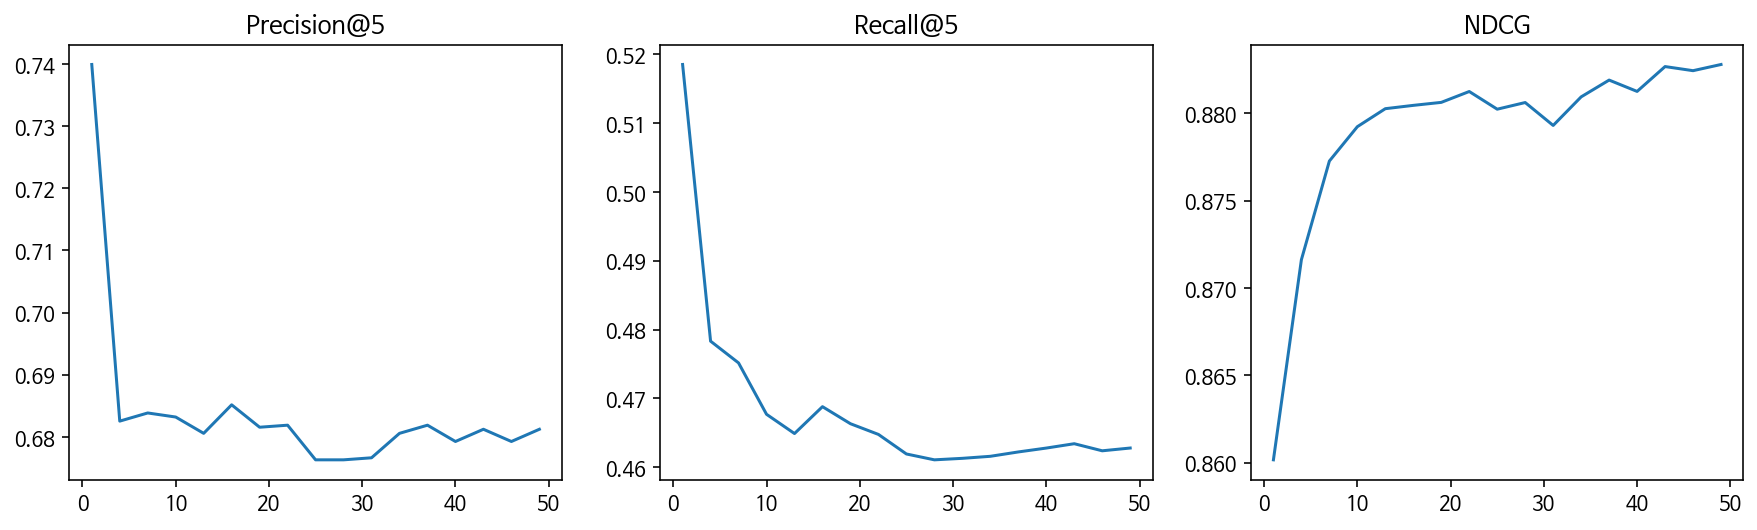

In [ ]:
def train_user_nn_based_recommendations(N):
  nearest_neighbors = np.argpartition(user_user_distance, N+1)[:,:N+1]
  pred_ratings_per_user = [np.squeeze(np.asarray(user_item_matrix[nearest_neighbors[user_id, :]].mean(axis=0))) for user_id in range(user_user_distance.shape[0])]
  user_nn_pred = []
  for user_id, title in zip(test_data["userId"], test_data["title"]):
    if user_id in user_id_to_idx and title in title_to_idx:
      # 학습 데이터에 존재하는 사용자와 영화의 경우 미리 평균낸 별점 데이터를 가져오자
      user_nn_pred.append(pred_ratings_per_user[user_id_to_idx[user_id]][title_to_idx[title]])
    # 학습 데이터에 존재하지 않는 사용자나 영화의 경우 0.0의 별점을 준다. 
    else: 
      user_nn_pred.append(0.0)
  return get_metrics(test_data, user_nn_pred)

rang = list(range(1,50,3))
precision = []
recall = []
ndcg = []
for n in rang:
  metrics = train_user_nn_based_recommendations(n)
  precision.append(metrics["Precision@5"])
  recall.append(metrics["Recall@5"])
  ndcg.append(metrics["NDCG@5"])

f, axs = plt.subplots(1, 3, figsize=[15, 4])
axs[0].plot(rang, precision)
axs[0].set_title('Precision@5')
axs[1].plot(rang, recall)
axs[1].set_title('Recall@5')
axs[2].plot(rang, ndcg)
axs[2].set_title('NDCG')


## 3. 모델 기반 협업 필터링

행렬 분해 알고리즘을 통해 각 사용자와 컨텐츠의 잠재 요인 벡터를 구하고 이를 바탕으로 추천하는 모델 기반 협업 필터링 알고리즘을 구현하자. 다시 복습하자면, 각 사용자와 컨텐츠마다 잠재 요인 벡터가 있고 사용자 A가 컨텐츠 B에게 준 별점은 A의 잠재 요인 벡터와 B의 잠재 요인 벡터의 내적값이다. 사용자 u의 잠재 요인 벡터를 x_u 그리고 컨텐츠 i의 잠재 요인 벡터를 y_u라 하면 다음과 같은 식에 따라 별점의 예측 값을 계산할 수 있다.

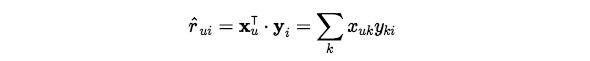

가장 적합한 잠재 요인 벡터는 예측한 별점과 관측된 별점의 차이를 최소화하는 값이다. 여기에 과적합을 막기위해 L2 Norm을 더하면 다음과 같은 목적 함수가 나온다. 

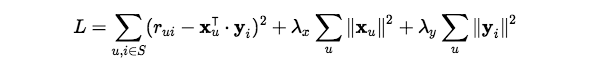

이 목적 함수를 최소화 시키는 방법은 여러가지가 있으나 이번 실습에서는 Alternating Least Squares기법을 이용해 최적화된 잠재 요인 벡터를 구해보자. 개념은 아주 간단하다. 컨텐츠 벡터를 고정시킨채로 최적합한 사용자 벡터를 찾고 그후 컨텐츠 벡터를 고정시킨채로 최적합한 사용자 벡터를 찾는다. 이를 계속 반복해나가며 최적합한 유저와 사용자 벡터를 찾는다. 

먼저 컨텐츠 벡터를 고정시킨채로 최적합한 사용자 벡터를 찾으려면 사용자 벡터로 편미분한 값을 0으로 만드는 사용자 벡터를 구해야한다. 이를 구하는 공식은 다음과 같다. 

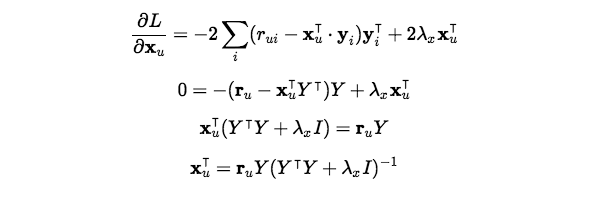

반대의 경우도 같은 방식으로 구할 수 있다. 이를 실제로 구현해보자. 

In [ ]:
from numpy.linalg import solve, norm

n_users, n_items = user_item_matrix.shape
# 잠재 요인 벡터의 길이
n_dimension = 10
user_reg = 0.1 # lambda_x
item_reg = 0.1 # lambda_y
# 먼저 잠재 요인 벡터를 랜덤하게 설정해주자
np.random.seed(1)
user_vectors = np.random.random((n_users, n_dimension))
item_vectors = np.random.random((n_items, n_dimension))

# 컨텐츠 벡터를 고정시킨채로 최적합한 사용자 벡터를 구하자
def als_step_user(user_vectors, item_vectors, user_item_matrix, user_reg):
  # 미리 계산해 놓자
  YTY = item_vectors.T.dot(item_vectors)
  lambdaI = np.eye(YTY.shape[0]) * user_reg

  for u in range(user_vectors.shape[0]):
    user_vectors[u, :] = solve((YTY + lambdaI), 
                                  user_item_matrix[u, :].dot(item_vectors).T).T

# 사용자 벡터를 고정시킨채로 최적합한 컨텐츠 벡터를 구하자
def als_step_item(user_vectors, item_vectors, user_item_matrix, item_reg):
  # 미리 계산해 놓자
  XTX = user_vectors.T.dot(user_vectors)
  lambdaI = np.eye(XTX.shape[0]) * item_reg

  for i in range(item_vectors.shape[0]):
    item_vectors[i, :] = solve((XTX + lambdaI), 
                                  user_item_matrix[:, i].T.dot(user_vectors).T).T

# 최적화 함수
def loss_function(user_vectors, item_vectors, user_item_matrix, user_reg, item_reg):
  return norm(user_item_matrix - user_vectors.dot(item_vectors.T)) ** 2 \
            + user_reg * norm(user_vectors) \
            + item_reg * norm(item_vectors)

def compute_test_metric(user_vectors, item_vectors, test_data):
  pred = []
  for user_id, title in zip(test_data["userId"], test_data["title"]):
    if user_id in user_id_to_idx and title in title_to_idx:
      # 학습 데이터에 존재하는 사용자와 영화의 경우 사용자 벡터와 컨텐츠 벡터의 내적을 구하자
      pred.append(user_vectors[user_id_to_idx[user_id], :].dot(item_vectors[title_to_idx[title], :]))
    # 학습 데이터에 존재하지 않는 사용자나 영화의 경우 0.0의 별점을 준다. 
    else: 
      pred.append(0.0)
  return get_metrics(test_data, np.array(pred))

# 이제 실제로 모델을 훈련시켜보자. 사용자 벡터와 컨텐츠 벡터를 업데이트 할때마다 
# 학습 데이터 그리고 테스트 데이터의 평가 지표를 측정하자.  
n_iterations = 10
training_loss = []
test_loss = []
precision = []
recall = []
ndcg = []
for i in range(n_iterations):
  print(f"Iteration {i}")
  als_step_user(user_vectors, item_vectors, user_item_matrix, user_reg)
  als_step_item(user_vectors, item_vectors, user_item_matrix, item_reg)
  training_loss.append(loss_function(user_vectors, item_vectors, user_item_matrix, user_reg, item_reg))
  metrics = compute_test_metric(user_vectors, item_vectors, test_data)
  test_loss.append(metrics["RMSE"] ** 2)
  precision.append(metrics["Precision@5"])
  recall.append(metrics["Recall@5"])
  ndcg.append(metrics["NDCG@5"])
  print(metrics)


Iteration 0
{'RMSE': 3.1845988842536315, 'Precision@5': 0.6589344262295082, 'Recall@5': 0.44873815304333486, 'NDCG@5': 0.8720802120555989}
Iteration 1
{'RMSE': 3.034890630697326, 'Precision@5': 0.6743442622950819, 'Recall@5': 0.4610977102053325, 'NDCG@5': 0.8802320003778511}
Iteration 2
{'RMSE': 3.014385682866007, 'Precision@5': 0.6812295081967213, 'Recall@5': 0.46498499783174774, 'NDCG@5': 0.8832860729579998}
Iteration 3
{'RMSE': 3.0036042022318257, 'Precision@5': 0.6854918032786885, 'Recall@5': 0.4651081286682645, 'NDCG@5': 0.886211277141048}
Iteration 4
{'RMSE': 2.9960662600993797, 'Precision@5': 0.6845081967213115, 'Recall@5': 0.4639475917569152, 'NDCG@5': 0.8859159974566615}
Iteration 5
{'RMSE': 2.990404479102865, 'Precision@5': 0.6854918032786885, 'Recall@5': 0.46244486892250664, 'NDCG@5': 0.8858542859775369}
Iteration 6
{'RMSE': 2.9858513903944375, 'Precision@5': 0.6822131147540984, 'Recall@5': 0.4607466306455488, 'NDCG@5': 0.8851183475616723}
Iteration 7
{'RMSE': 2.982148429172

Text(0.5, 1.0, 'NDCG')

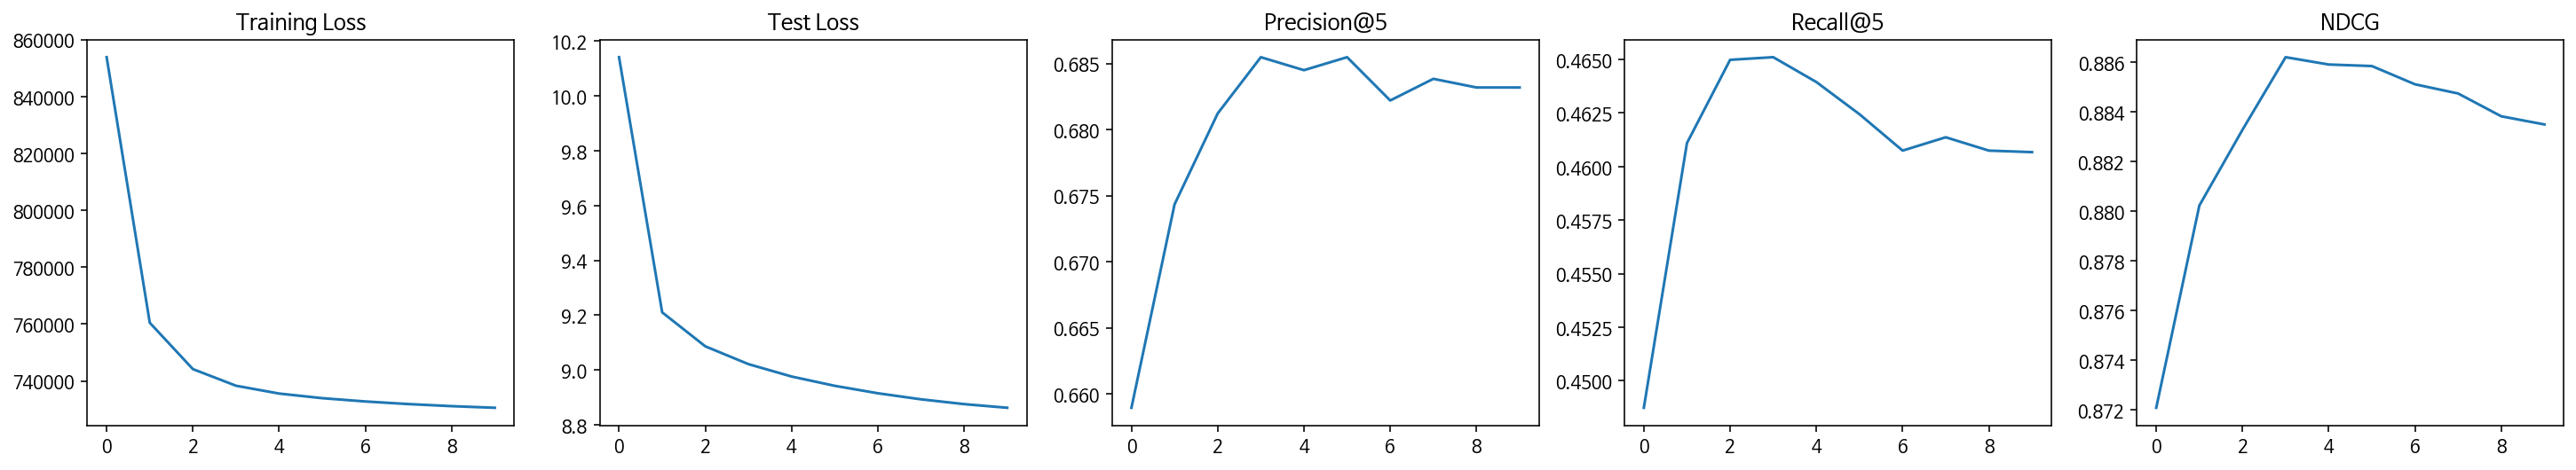

In [ ]:
f, axs = plt.subplots(1, 5, figsize=[25, 4])
axs[0].plot(range(n_iterations), training_loss)
axs[0].set_title('Training Loss')
axs[1].plot(range(n_iterations), test_loss)
axs[1].set_title('Test Loss')
axs[2].plot(range(n_iterations), precision)
axs[2].set_title('Precision@5')
axs[3].plot(range(n_iterations), recall)
axs[3].set_title('Recall@5')
axs[4].plot(range(n_iterations), ndcg)
axs[4].set_title('NDCG')

첫번째와 두번째 사이클에서 지표가 급격히 좋아지며 그후에는 서서히 좋아지는 것을 볼 수 있다. 테스트 데이터 상의 목적 함수도 계속 줄고 있는 것을 보면 아직 과적합은 일어나지 않은 것을 볼 수 있다. 

그렇다면 훈련된 모델을 바탕으로 Spot checking은 어떻게 할까? 입력 별점 데이터를 바탕으로 레이팅 벡터를 만들면 컨텐츠 벡터는 훈련이 완료되었으니 고정시킨채로 사용자 벡터를 구하면 된다. 

In [ ]:
# 사용자의 별점 데이터 (영화 이름 -> 별점)을 바탕으로 어떤 영화들을 추천해줄까?
def get_mf_recommendations(rating_dict, n_recs):
  mat = convert_rating_dict_to_vector(rating_dict)
  user_vector = np.random.random((1, n_dimension))
  als_step_user(user_vector, item_vectors, mat, user_reg)
  pred_ratings = np.squeeze(np.asarray(user_vector.dot(item_vectors.T)))
  return [titles[id] for id, _ in heapq.nlargest(n_recs, enumerate(pred_ratings), key=lambda tup: tup[1])]

print(user1)
print(get_mf_recommendations(user1, 5))
print(user2)
print(get_mf_recommendations(user2, 5))

{'Forrest Gump (1994)': 5.0, 'Star Wars: Episode IV - A New Hope (1977)': 1.0}
['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Braveheart (1995)']
{'Forrest Gump (1994)': 1.0, 'Star Wars: Episode IV - A New Hope (1977)': 5.0}
['Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Forrest Gump (1994)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)']


평가지표를 더욱 최적화하기 위해서는 잠재 요인 벡터 길이, 사용자 정규화 계수, 컨텐츠 정규화 계수 등의 초매개변수를 바꿔가며 가장 평가지표가 좋은것은 고르면 된다. 실무에서는 AutoML 기법들을 통해 이를 자동으로 찾아준다. 

# 정리하기

이번 실습을 통해 영화 별점 데이터를 분석하고 이를 바탕으로 다양한 추천 알고리즘들을 구현해보았다. 이를 바탕으로 다양한 실험들을 돌려보며 평가 지표를 어떻게하면 최적화할 수 있을지 고민해보자. 물론 위의 구현 방법 이외에도 [scikit-learn](https://scikit-learn.org/stable/) 패키지나 [Tensorflow Recommenders](https://www.tensorflow.org/recommenders) 패키지 등을 사용하면 다양한 추천 알고리즘들을 더 손쉽게 구현해볼 수 있으니 이들을 이용해보길 추천한다. 